# Lab 4-: Mixture Models+Model orden selection 

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions.

We begin with the standard imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from sklearn.cluster import KMeans

## Question 1:
**1-** for i in {1,2..K} we have: 
$ \quad \pi_i^{n+1} = P(Z = i|X,\theta_n) = \frac{f_{| X,\theta_n (Z = i) * P(Z = i)}}{ \sum {f_{| X,\theta_n (Z = k)} * P(Z = k)} }$

where $ f_{| X,\theta_n (Z = i) * P(Z = i)} = \frac{1}{\sqrt{ {2*\pi}^p * |\sum|}}  * e^{-0.5 * (X-\mu)^T * \sum^{-1} * (X-\mu)}$ 

**2-** We have then by using maximum likelihood:
for i in {1,2..K}: $ \mu_i = \frac{\sum \pi_i^{n+1} * X_j}{\sum \pi_i^{n+1}}$

**3-** Using the same logic we have: 
for i in {1,2..K}: $ \sigma_i^2 =  \frac{\sum \pi_i^{n+1} * (X_j - \mu_i)^2}{\sum \pi_i^{n+1}}$


## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [117]:
class my_GMM():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        def density(x , mu, sigma):
            p = x.shape[0]
            return  (1/(np.sqrt((2*np.pi)**p * np.linalg.det(sigma))))  * np.exp(-0.5 * (x-mu).T @ np.linalg.inv(sigma) @ (x-mu))
        def compute_condition_prob_matrix(X, alpha, mu, Sigma):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            n,p = X.shape
            k = len(alpha)
            res = np.zeros((n,k))
            for i in range(n):
                for j in range(k):
                    res[i,j] = alpha[j] * density(X[i], mu[j], Sigma[j]) # the normalization at the end of the function
            res = res/ np.sum(res, axis = 0)
            return res 
        
        # TODO:
        # initialize the parameters
        # model = KMeans(n_clusters= self.k)
       
        n,p = X.shape
        kmeans = KMeans(n_clusters=self.k).fit(X)
        mu = kmeans.cluster_centers_
        sigma = np.array([np.eye(p) for j in range(self.k)])
        alpha = np.zeros(self.k)
        for j in range(self.k):
            alpha[j] = np.count_nonzero(kmeans.labels_==j)/n
        
        # While not(convergence)
        #     Compute conditional probability matrix
        #     Update parameters
        
        # the convergence can be seen from different angels: for example the conditional proba didn't change much 
        eps = 0.0001
        current_cond_proba = compute_condition_prob_matrix(X, alpha, mu, sigma)
        previous_cond_proba = 2 * current_cond_proba # just to enter the loop
        while np.mean(np.abs(current_cond_proba - previous_cond_proba)) < eps:
            alpha = np.mean(current_cond_proba, axis = 0)
            mu = (current_cond_proba.T @ X) / np.sum(current_cond_proba, axis = 0)   # dim k,p 
            sigma = (current_cond_proba.T @ (X-mu)**2) / np.sum(current_cond_proba, axis = 0)
            current_cond_proba, previous_cond_proba = compute_condition_prob_matrix(X, alpha, mu, sigma), current_cond_proba
        self.mu_ = mu
        self.alpha_ = alpha 
        self.Sigma_ = sigma
        self.cond_prob_ = current_cond_proba
        self.labels_ = np.argmax(self.cond_prob_, axis= 1)
        return self.labels_
        
    def predict(self, X, mode = 'hard'):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        # TODO
        def density(x , mu, sigma):
                return  (1/(np.sqrt((2*np.pi)**p * np.linalg.det(sigma))))  * np.exp(0.5 * (x - mu).T@np.linalg.inv(sigma)@(x-mu))
        n,p = X.shape
        k = self.k
        res = np.zeros((n,k))
        for i in range(n):
            for j in range(k):
                res[i,j] = self.alpha[j] * density(X[i], self.mu_[j], self.Sigma_[j]) # the normalization at the end of the function
            res = res/ np.sum(res, axis = 1)
        if mode == 'hard':
            return np.argmax(res, axis= 1)
        else:
            return res
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        # TODO
        return self.predict(X, 'soft')

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [121]:
# to generate cases where kmeans perform poorly than a gmm we need to list the limitations of kmeans :
# it assumes that all the classes have the same proportion and the same covariance matrix and prefers spherical shapes
# so let's just generate data that does not respect this requirement 
def generate_data(size, k_classes):
    alpha = np.random.uniform(1,2, k_classes)
    alpha = alpha/sum(alpha)

    mu = np.random.choice(np.arange(-5,5), size=(k_classes, 2))
    sigma = np.array([np.random.uniform(0,1) * np.eye(2) for i in range(k_classes)])

    X = []
    # we need to generate n label according to a binomial distribution 
    # it is like we throw one dice size-time 
    labels = np.random.multinomial(n = 1, pvals= alpha, size = size)
    labels = np.argwhere(labels == 1)[:,1]

    return np.array([np.random.multivariate_normal(mean=mu[labels[i]], cov= sigma[labels[i]]) for i in range(size)]), labels 

size, k_classes = 2000, 4 
data, labels = generate_data(size, k_classes)
import plotly.express as px 
px.scatter(x = data[:,0],y =  data[:,1], color=labels )


In [122]:
my_gmm = my_GMM(k_classes)
labels = my_gmm.fit(data)
px.scatter(x = data[:,0],y =  data[:,1], color=labels )

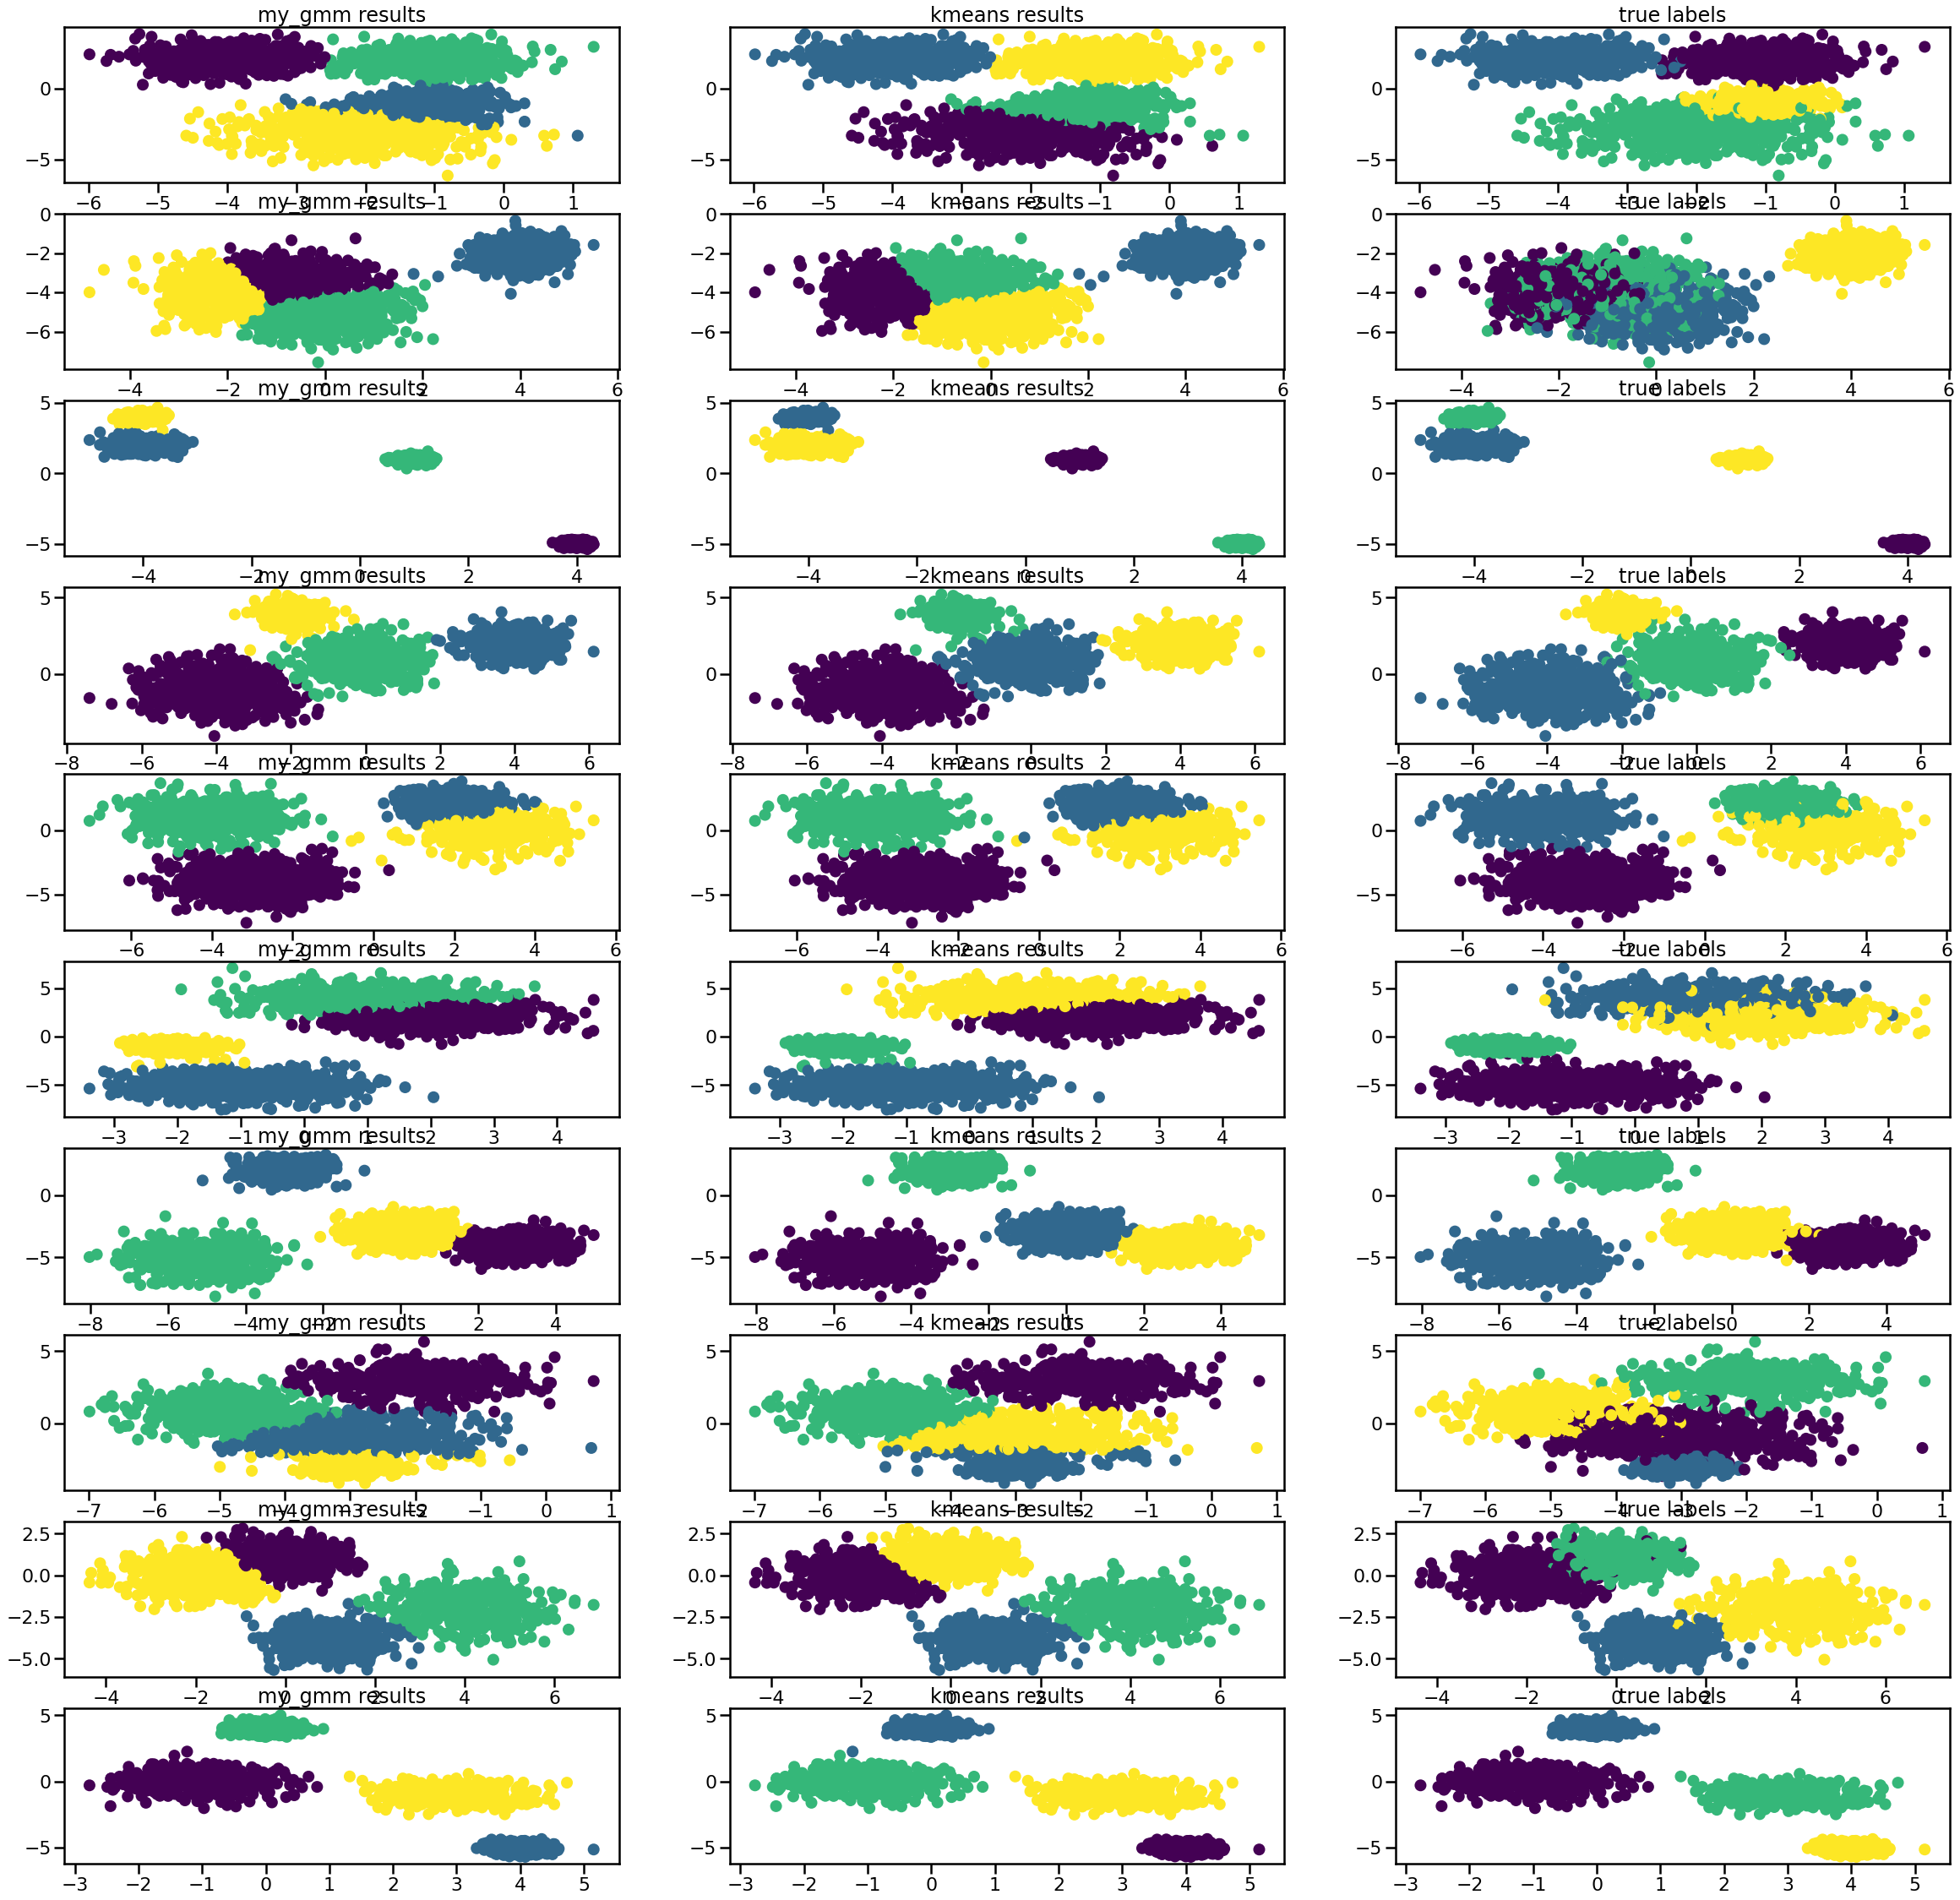

In [123]:
# let's test our models on the created data 
trials_number = 10
fig,axes = plt.subplots(trials_number, 3, figsize = (40,40))
for i in range(trials_number):
    data, true_labels = generate_data(size, k_classes)
    kmeans = KMeans(n_clusters= k_classes)
    kmeans.fit(data)
    my_gmm = my_GMM(k_classes)
    labels_gmm = my_gmm.fit(data)
    axes[i,0].scatter(x = data[:,0],y =  data[:,1], c= labels_gmm)
    axes[i,0].set_title('my_gmm results')
    axes[i,1].scatter(x = data[:,0],y =  data[:,1], c= kmeans.labels_)
    axes[i,1].set_title('kmeans results')
    axes[i,2].scatter(x = data[:,0],y =  data[:,1], c= true_labels)
    axes[i,2].set_title('true labels')
plt.show()


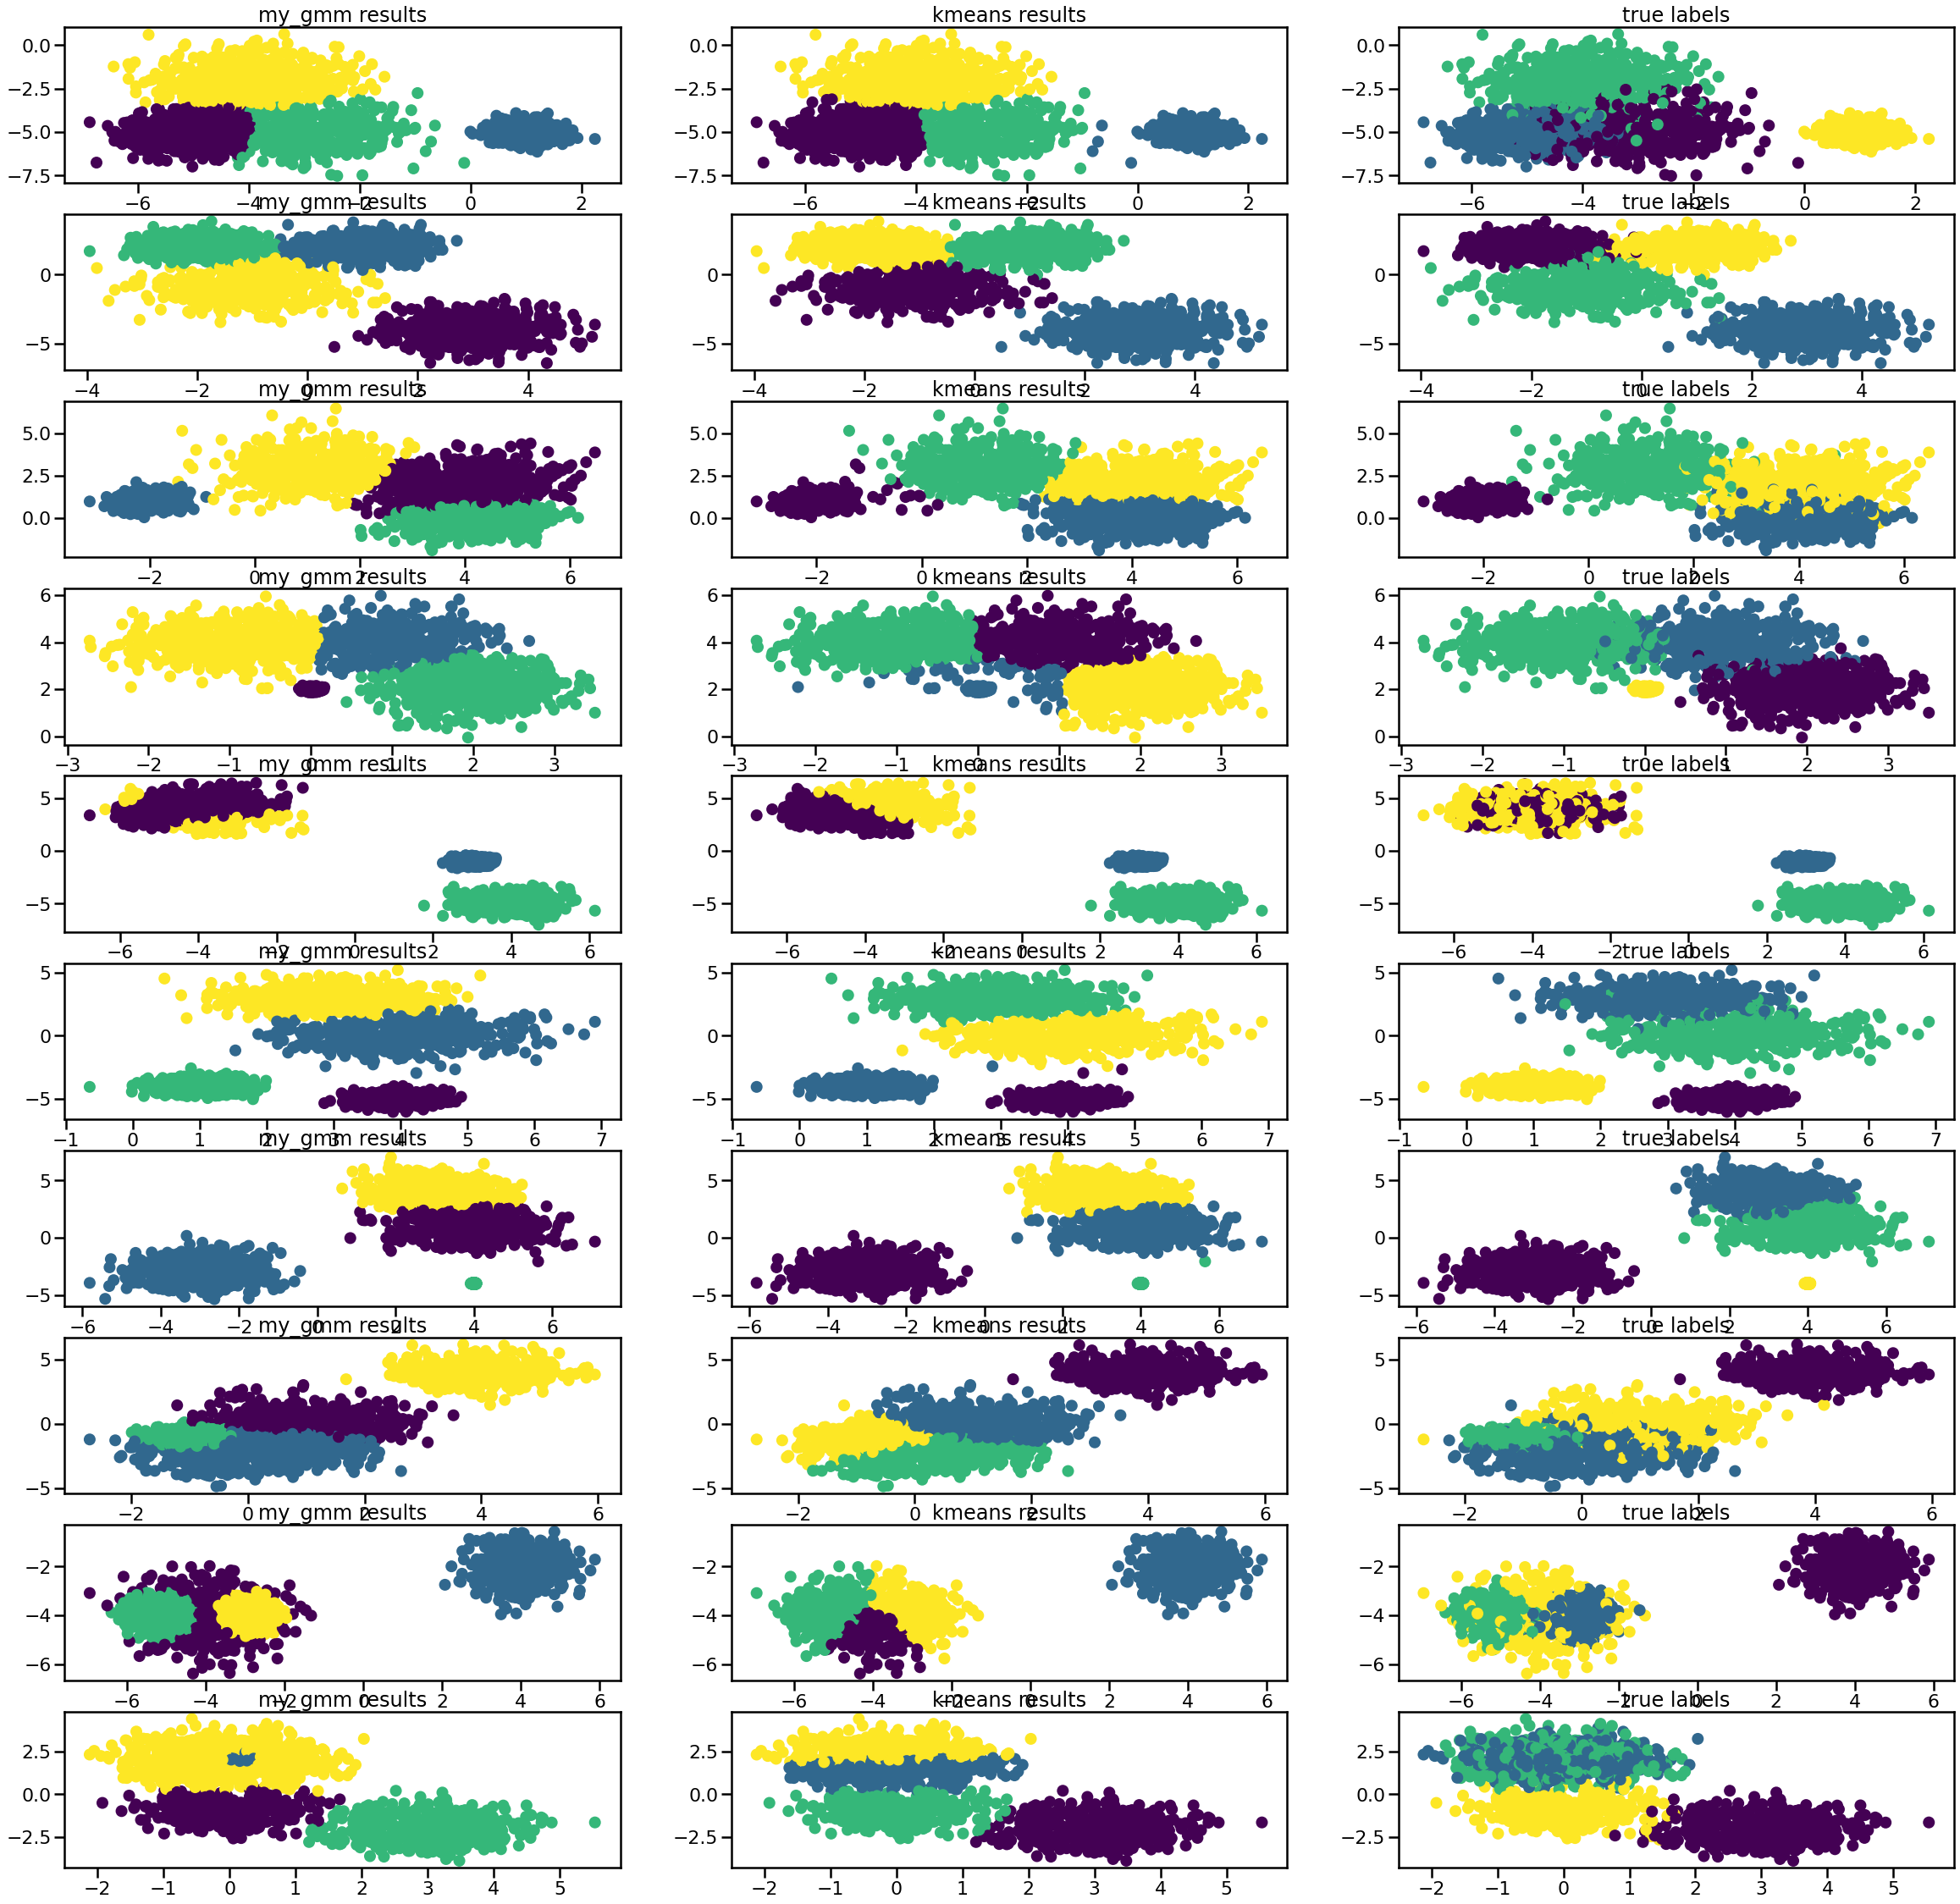

In [126]:
# let's test our models on the created data 
trials_number = 10
fig,axes = plt.subplots(trials_number, 3, figsize = (40,40))
for i in range(trials_number):
    data, true_labels = generate_data(size, k_classes)
    kmeans = KMeans(n_clusters= k_classes)
    kmeans.fit(data)
    my_gmm = my_GMM(k_classes)
    labels_gmm = my_gmm.fit(data)
    axes[i,0].scatter(x = data[:,0],y =  data[:,1], c= labels_gmm.labels_)
    axes[i,0].set_title('my_gmm results')
    axes[i,1].scatter(x = data[:,0],y =  data[:,1], c= kmeans.labels_)
    axes[i,1].set_title('kmeans results')
    axes[i,2].scatter(x = data[:,0],y =  data[:,1], c= true_labels)
    axes[i,2].set_title('true labels')
plt.show()


**Conclusion :** We can obviously see that KMeans tend to cluster classes with same number of points when these classes are close to each other, but out GMM model have better perfomances.